# 5.2 A/B тесты

* Эксперимент проходил с 2023-05-31 по 2023-06-06 включительно. 
* Для эксперимента были задействованы 2 и 1 группы. 
* В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 
* Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR. 

In [1]:
import pandas as pd
import pandahouse as ph
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import poisson

connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230620',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

In [2]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') AS likes,
    sum(action = 'view') AS views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2023-05-31' AND '2023-06-06'
    AND exp_group IN (1,2)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.exp_group.value_counts()

exp_group
1    10079
2     9952
Name: count, dtype: int64

In [3]:
group1 = df[df.exp_group==1].ctr
group2 = df[df.exp_group==2].ctr

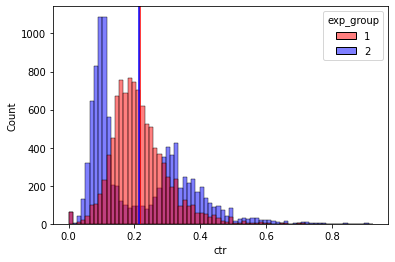

In [4]:
groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group',
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)
              
plt.axvline(x=group1.mean(), color='red')
plt.axvline(x=group2.mean(), color='blue')


### Комментарии

1. Видно, что распределения разные. 
2. Однако раница имеет такой характер, что средние распределений равны.
3. Это отразится на результатах параметрических тестов (которые желательно не использовать, так как распределение Группы очень отклоняется от одномодального нормального).
4. Распределение в группе 2 - двумодальное, что говорит о том, что новый алгоритм рекомендация разделил пользователй на тех, кто стал ставить больше лайков, и тех, кто наоборот, меньше.
5. Видимо, внутри группы есть какое-то различие, которое поляризует результаты эксперимента.

## 1. A/B Тест - t-test

* **alpha** = 5
* Гипотеза, что во второй группе  CTR выше, но доподлинно мы не знаем, как наш эксперимент повлиял на метрику, поэтому мы выбираем **two-sided hypothesis**.
* нам неизвестно, равны ли дисперсии - выбираем **Welch's t-test**.
----
   *   **Hₒ: mean1  = mean2** 
   *   **Hₐ: mean1 ≠ mean2**

In [5]:
alpha = 0.05
t, p_value = ttest_ind(group1, group2, equal_var=False)
print('p-value is', p_value)
if p_value <= alpha:
    print('Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2')
else:
    print('У нас недостаточно оснований, чтобы отклонить нулевую гипотезу')

p-value is 0.4780623130874935
У нас недостаточно оснований, чтобы отклонить нулевую гипотезу


Параметрический тест предсказуемо не смог уловить разницу там, где она есть, потому что для бимодальных распределений он и не подходит.

## 2. Непараметрический тест Манна-Уитни

Это тест для наших распределений должен подойти больше.

   *   **Hₒ**: между группами 1 и 2 нет разницы
   *   **Hₐ**: разница есть

In [6]:
mw, p_value_mw = mannwhitneyu(group1, group2,
                           alternative = 'two-sided')
print('p-value is', p_value_mw)
if p_value_mw <= alpha:
    print('Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2')
else:
    print('У нас недостаточно оснований, чтобы отклонить нулевую гипотезу')

p-value is 6.0376484617779035e-56
Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2


## 3. T-тест на сглаженном CTR

Задача сглаживания - убрать шум из-за тех, пользователей, у которых мало просмотров и чей ctr нам ни о чем не говорит.

In [7]:
#определение функции (сглаживание Лапласа)

def get_smoothed_ctr(user_likes, user_views, global_ctr, alpha):
    smoothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
    return smoothed_ctr

In [8]:
#cглаживание

global_ctr_1 = df[df.exp_group == 1].likes.sum()/df[df.exp_group == 1].views.sum()
global_ctr_2 = df[df.exp_group == 2].likes.sum()/df[df.exp_group == 2].views.sum()

group1_smoothed = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_1, 5), axis=1)
group2_smoothed = df.apply(
    lambda x: get_smoothed_ctr(x['likes'], x['views'], global_ctr_2, 5), axis=1)

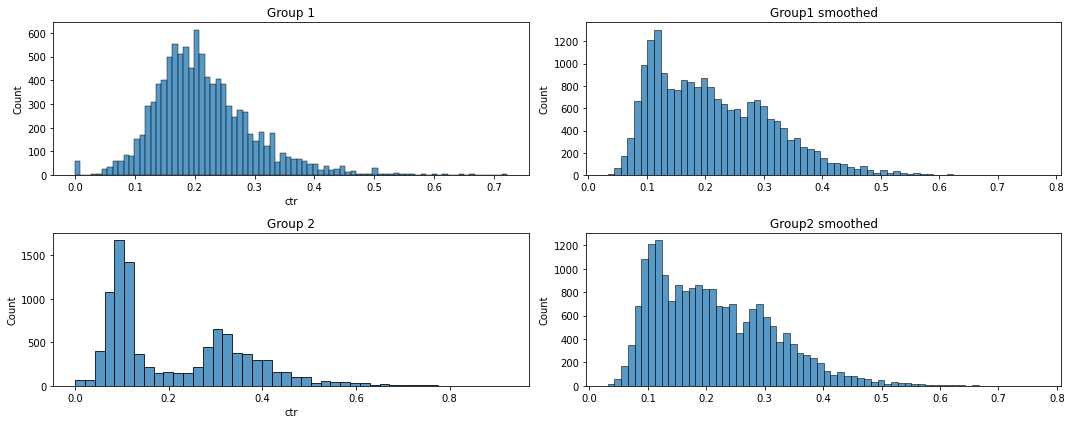

In [9]:
#визуализация

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2,ncols=2, figsize=(15, 6))
sns.histplot(data=group1, kde=False, ax=ax1)
ax1.set_title("Group 1")
sns.histplot(data=group1_smoothed, kde=False, ax=ax2)
ax2.set_title("Group1 smoothed")
sns.histplot(data=group2, kde=False, ax=ax3)
ax3.set_title("Group 2")
sns.histplot(data=group2_smoothed, kde=False, ax=ax4)
ax4.set_title("Group2 smoothed")
plt.tight_layout()

In [10]:
t, p_value_smoothed = ttest_ind(group1_smoothed, group2_smoothed, equal_var=False)
print('p-value is', p_value_smoothed)
if p_value_smoothed <= alpha:
    print('Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2')
else:
    print('У нас недостаточно оснований, чтобы отклонить нулевую гипотезу')

p-value is 0.2933942442811711
У нас недостаточно оснований, чтобы отклонить нулевую гипотезу


## 4. Пуассоновский Бутстреп 

* Допущение:
Наши выборки из групп являются хорошей моделью генеральной совокупности.

* Это позволяет нам генерировать много выборок на основе двух имеющихся.

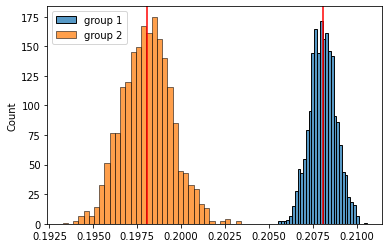

In [11]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap=2000):

    poisson_bootstraps1 = poisson(1).rvs((n_bootstrap, len(likes1))).astype(np.int64)

    poisson_bootstraps2 = poisson(1).rvs((n_bootstrap, len(likes2))).astype(np.int64)
    
    globalCTR1 = (poisson_bootstraps1*likes1).sum(axis=1)/(poisson_bootstraps1*views1).sum(axis=1)
    
    globalCTR2 = (poisson_bootstraps2*likes2).sum(axis=1)/(poisson_bootstraps2*views2).sum(axis=1)

    return globalCTR1, globalCTR2



likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()


ctr1_bts, ctr2_bts = bootstrap(likes1, views1, likes2, views2)
sns.histplot(ctr1_bts, label='group 1')
sns.histplot(ctr2_bts, label='group 2')
plt.axvline(x=ctr1_bts.mean(), color='red')
plt.axvline(x=ctr2_bts.mean(), color='red')
plt.legend()

### Комментарий

1. Гистограммы выше говорят, что значения CTR ниже для группы 2, чем для группыа 1 (контрольной).
2. Одна из мод в группе 2 была ниже среднего (и моды) по группе 1, это и изменило картину распределения после пуассоновского бутстрепа.
3. И два распределения даже не пересекаются - t-test для такого будет просто формальностью.

Text(0.5, 1.0, 'Распределение разницы')

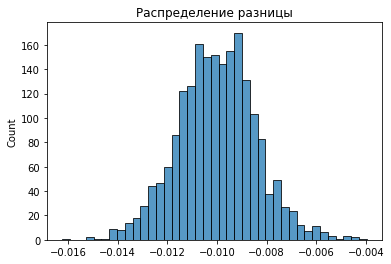

In [12]:
sns.histplot(ctr2_bts - ctr1_bts)
plt.title('Распределение разницы')

### Комментарий

На гистограмме снова видно, что разница явно есть (нулевая разница не представлена).

In [13]:
# t-test 

t, p_value_bts = ttest_ind(ctr1_bts, ctr2_bts, equal_var=False)
print('p-value is', p_value_bts)
if p_value_bts <= alpha:
    print('Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2')
else:
    print('У нас недостаточно оснований, чтобы отклонить нулевую гипотезу')

p-value is 0.0
Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2


## 5. Бакетное преобразование

* Бакетное преобразование поможет еще больше рандомизовать выборки и улучшить баланс между группами.
* Число бакетов = 50

In [19]:
q2 = """

SELECT exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
FROM (SELECT exp_group, 
        xxHash64(user_id)%50 as bucket,
        user_id,
        sum(action = 'like') as likes,
        sum(action = 'view') as views,
        likes/views as ctr
    FROM {db}.feed_actions 
    WHERE toDate(time) between '2023-05-31' AND '2023-06-06'
        and exp_group in (1,2)
    GROUP BY exp_group, bucket, user_id)
GROUP BY exp_group, bucket
"""

df2 = ph.read_clickhouse(q2, connection=connection)
df2.exp_group.value_counts()

exp_group
1    50
2    50
Name: count, dtype: int64

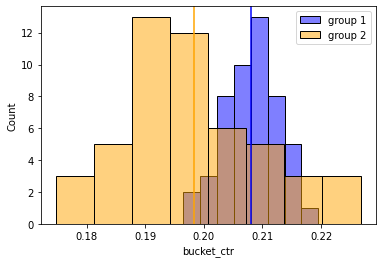

In [15]:
sns.histplot(df2[df2.exp_group == 1].bucket_ctr, label='group 1', color='blue', alpha=0.5)
sns.histplot(df2[df2.exp_group == 2].bucket_ctr, label ='group 2', color='orange', alpha=0.5)
plt.axvline(df2[df2.exp_group == 1].bucket_ctr.mean(), color='blue')
plt.axvline(df2[df2.exp_group == 2].bucket_ctr.mean(), color='orange')
plt.legend()

### Комментарий
1. Видно, что CTR в группе 2 имеет гораздо больший размах при меньшем среднем.
2. Это говорит о том, что в группе два результаты менее однородны (что было видно и на самой первой гистограмме).

In [20]:
#t-test

t, p_value_b = ttest_ind(df2[df2.exp_group == 1].bucket_ctr,
                         df2[df2.exp_group == 2].bucket_ctr, equal_var=False)
print('p-value is', p_value_b)
if p_value_b <= alpha:
    print('Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2')
else:
    print('У нас недостаточно оснований, чтобы отклонить нулевую гипотезу')

p-value is 3.4455951649945907e-07
Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2


In [17]:
#тест Манна-Уитни 
mw, p_value_b_mw = mannwhitneyu(df2[df2.exp_group == 1].bucket_ctr, 
                   df2[df2.exp_group == 2].bucket_ctr, 
                   alternative = 'two-sided')
print('p-value is', p_value_b_mw)
if p_value_b_mw <= alpha:
    print('Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2')
else:
    print('У нас недостаточно оснований, чтобы отклонить нулевую гипотезу')

p-value is 2.859963936492646e-07
Мы можем отклонить нулевую гипотезу о равенстве CTR в группах 1 и 2


##  **Итог**

In [18]:
p_vals = pd.DataFrame(index=['t-test', 'mw', 't (smoothed ctr)', 't (bootstarp)', 't (buckets)', 'mw (buckets)'], 
                      columns=['p-value'],
                      data = map(lambda x: round(x, 4), 
                                 [p_value, p_value_mw, p_value_smoothed, p_value_bts, p_value_b, p_value_b_mw]))
                      
p_vals

,p-value
t-test,0.4781
mw,0.0000
t (smoothed ctr),0.2934
t (bootstarp),0.0000
t (buckets),0.0000
mw (buckets),0.0000


1. Разница в распредлениях видна даже на графиках, и большинство из тестов выше считают разницу статистически значимой.
2. Однако разница это неодназначная. Тестовая группа поляризовалась - новый алгоритм повысил CTR в одной ее части и понизил в другой.
3. На гистограммах после пуассоновского бутстрепа два распределения даже не пересекаются, и группа 2 - левее граппы 1.
4. Поэтому гипотезу о том, что новый алгоритм рекомендаций повышает CTR нельзя принять.
5. **И раскатывать новый алгоритм на всех новых пользователей не стоит**.

### Почему распределение в группе 2 двумодальное?

Возможно, какие-то характеристики пользователей определили их ctr. Например, для женщин алгоритм сработал лучше, или для молодежи.

In [29]:
q3 = """
SELECT user_id, gender, age, os, country, ctr
FROM

(SELECT user_id,   
    sum(action = 'like') AS likes,
    sum(action = 'view') AS views,
    likes/views as ctr
FROM {db}.feed_actions
WHERE toDate(time) between '2023-05-31' AND '2023-06-06'
    AND exp_group = 2
GROUP BY user_id) t1

INNER JOIN

(SELECT distinct(user_id), gender, age, country, os
FROM {db}.feed_actions) t2

USING user_id

"""

df3 = ph.read_clickhouse(q3, connection=connection)
df3.head()

,user_id,gender,age,os,country,ctr
0,128357,0,20,iOS,Russia,0.295918
1,128879,0,36,Android,Russia,0.288889
2,119315,1,15,Android,Russia,0.312500
3,22790,1,41,iOS,Russia,0.330935
4,23826,1,14,iOS,Russia,0.113475


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, 'Russia'),
  Text(1, 0, 'Belarus'),
  Text(2, 0, 'Azerbaijan'),
  Text(3, 0, 'Ukraine'),
  Text(4, 0, 'Turkey'),
  Text(5, 0, 'Switzerland'),
  Text(6, 0, 'Kazakhstan'),
  Text(7, 0, 'Finland'),
  Text(8, 0, 'Estonia'),
  Text(9, 0, 'Latvia'),
  Text(10, 0, 'Cyprus')])

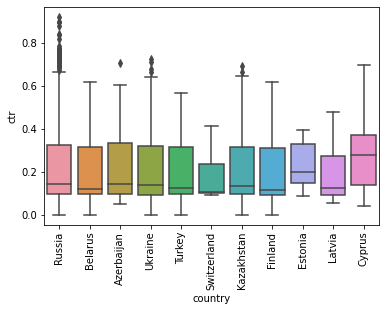

In [45]:
sns.boxplot(df3, x='country', y='ctr')
plt.xticks(rotation=90)

<Axes: xlabel='os', ylabel='ctr'>

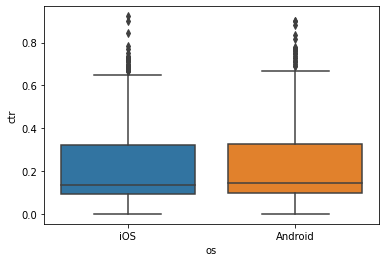

In [39]:
sns.boxplot(df3, x='os', y='ctr')

<Axes: xlabel='gender', ylabel='ctr'>

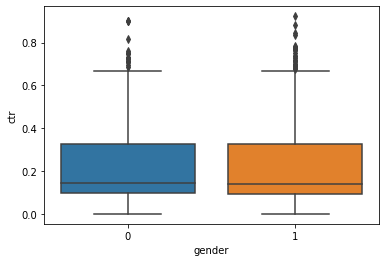

In [41]:
sns.boxplot(df3, x='gender', y='ctr')

<Axes: xlabel='age', ylabel='ctr'>

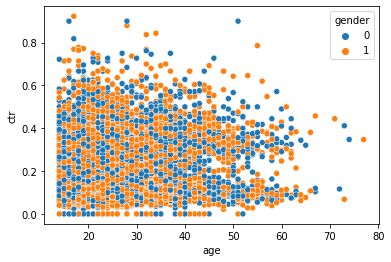

In [43]:
sns.scatterplot(df3, x='age', y='ctr', hue='gender')

### Комментарий

1. На графиках не видно никакого паттерна, который мог бы объяснить бимодальность. 
2. Возможно, на такие разделенные результаты повлияли другие, неучтенные внутренние характеристики пользователей.
3. Или естесвенные различия во вкусах и предпочтениях.
4. Или неучтенные внешние факторы, разница в характере самих постов, информационных поводов, особенный тайминг и т.п.